## [1] Setup e Import

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import asyncio
import json

# path del server MCP
sys.path.insert(0, str(Path.cwd().parent / 'mcp_server'))


## [2] Caricamento Dati

Il dataset contiene:
- **Users**: 20 utenti
- **Items**: 30 items (ID: 101-130)
- **Ratings**: ~180 valutazioni (scala 1-5)

In [2]:
# Carica il dataset
data_path = Path.cwd().parent / 'data' / 'ratings.csv'
df = pd.read_csv(data_path)

print(f" Dataset caricato: {len(df)} ratings")
print(f"   Utenti unici: {df['user_id'].nunique()}")
print(f"   Items unici: {df['item_id'].nunique()}")
print(f"   Rating medio: {df['rating'].mean():.2f}")
print("\n Prime 10 righe:")
df.head(10)

 Dataset caricato: 182 ratings
   Utenti unici: 20
   Items unici: 31
   Rating medio: 3.75

 Prime 10 righe:


,user_id,item_id,rating
0,1,101,5.0
1,1,104,4.0
2,1,107,4.0
3,1,108,3.0
4,1,116,5.0
5,1,119,5.0
6,1,121,2.0
7,1,122,4.0
8,1,123,3.0
9,1,125,5.0


## [3] Analisi Esplorativa dei Dati

In [3]:
# Statistiche per utente
user_stats = df.groupby('user_id').agg({
    'item_id': 'count',
    'rating': ['mean', 'std']
}).round(2)

user_stats.columns = ['num_ratings', 'avg_rating', 'std_rating']
user_stats = user_stats.sort_values('num_ratings', ascending=False)

print("Top 10 utenti più attivi:")
user_stats.head(10)

Top 10 utenti più attivi:


,num_ratings,avg_rating,std_rating
user_id,,,
1,14,4.14,0.93
7,13,3.54,1.33
12,13,3.92,1.19
15,11,3.64,1.03
3,11,3.91,0.70
17,11,3.82,1.17
2,11,3.45,1.04
8,10,3.00,1.49
9,10,4.20,0.63


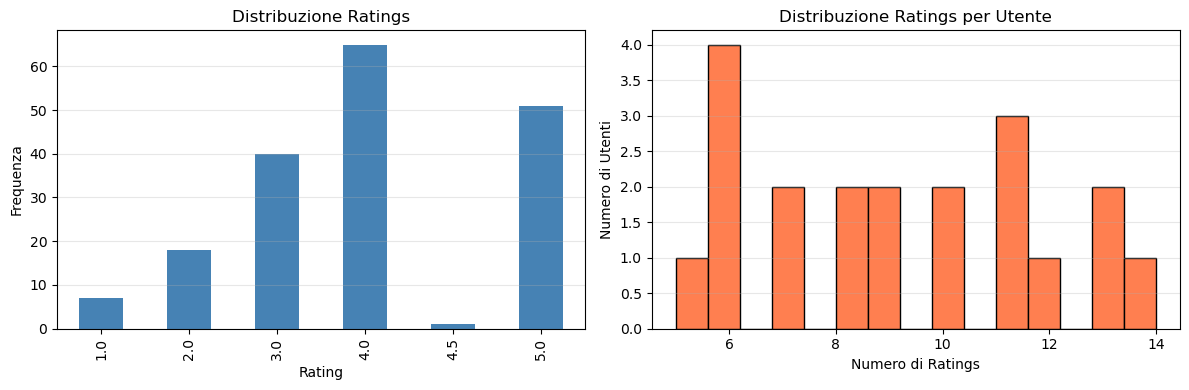

Sparsity: 70.6%


In [3]:
# Distribuzione dei ratings
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribuzione ratings
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuzione Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequenza')
axes[0].grid(axis='y', alpha=0.3)

# Ratings per utente
ratings_per_user = df.groupby('user_id').size()
axes[1].hist(ratings_per_user, bins=15, color='coral', edgecolor='black')
axes[1].set_title('Distribuzione Ratings per Utente')
axes[1].set_xlabel('Numero di Ratings')
axes[1].set_ylabel('Numero di Utenti')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sparsity: {(1 - len(df) / (df['user_id'].nunique() * df['item_id'].nunique())) * 100:.1f}%")

## [4] Test delle Funzioni MCP Server

Importiamo e testiamo le funzioni del server MCP direttamente.

In [4]:
# Import delle funzioni dal server MCP
from recommender_server import (
    load_or_initialize_data,
    get_recommendations,
    add_rating,
    get_similar_users,
    get_user_stats
)

# Inizializza i dati
load_or_initialize_data()
print("Server MCP inizializzato")

Loaded 182 ratings from c:\Users\Patrick\Desktop\progetto\data\ratings.csv


Server MCP inizializzato


### 4.1 - Statistiche Utente

In [22]:
# Test: Ottieni statistiche per un utente
user_id = 5

result = await get_user_stats(user_id=user_id)
stats = eval(result)  # Converti stringa a dict

print(f"Statistiche Utente {user_id}:")
print(f"   Total ratings: {stats['total_ratings']}")
print(f"   Average rating: {stats['average_rating']:.2f}")
print(f"   Min rating: {stats['min_rating']}")
print(f"   Max rating: {stats['max_rating']}")
print(f"   Rated items: {stats['rated_items']}")

Statistiche Utente 5:
   Total ratings: 10
   Average rating: 3.20
   Min rating: 2.0
   Max rating: 5.0
   Rated items: [107, 108, 110, 114, 116, 117, 120, 128, 130, 105]


### 4.2 - Utenti Simili

In [10]:
user=1
# Test: Trova utenti simili
result = await get_similar_users(user_id=user, top_n=5)
similar = eval(result)

print(f"[SIMILARITY] Utenti simili a User {similar['user_id']}:\n")
for sim_user in similar['similar_users']:
    print(f"   User {sim_user['user_id']}: similarity = {sim_user['similarity_score']:.4f}")

[SIMILARITY] Utenti simili a User 1:

   User 19: similarity = 1.0000
   User 6: similarity = 1.0000
   User 4: similarity = 0.9949
   User 18: similarity = 0.9944
   User 14: similarity = 0.9939


### 4.3 - Raccomandazioni (Collaborative Filtering)

In [11]:
user=1
# Test: Ottieni raccomandazioni
result = await get_recommendations(user_id=user, top_n=5)
recommendations = eval(result)

print(f"[RECOMMENDATIONS] Raccomandazioni per User {recommendations['user_id']}:\n")
for rec in recommendations['recommendations']:
    print(f"   Item {rec['item_id']}: predicted rating = {rec['predicted_rating']:.2f}")

[RECOMMENDATIONS] Raccomandazioni per User 1:

   Item 114: predicted rating = 4.58
   Item 110: predicted rating = 4.50
   Item 105: predicted rating = 4.26
   Item 103: predicted rating = 4.21
   Item 127: predicted rating = 4.01


### 4.4 - Aggiungi Nuovo Rating

In [21]:
user=5
item_id=105
rating=2

# Test: Aggiungi un nuovo rating
result = await add_rating(user_id=user, item_id=item_id, rating=rating)
print(result)

# Verifica le nuove raccomandazioni
result = await get_recommendations(user_id=2, top_n=3)
new_recommendations = eval(result)

print(f"\n Nuove raccomandazioni dopo il rating:")
for rec in new_recommendations['recommendations']:
    print(f"   Item {rec['item_id']}: predicted rating = {rec['predicted_rating']:.2f}")

Updated rating: User 5 rated Item 105 as 2


Updated rating: User 5 rated Item 105 as 2

 Nuove raccomandazioni dopo il rating:
   Item 114: predicted rating = 4.57
   Item 103: predicted rating = 4.22
   Item 108: predicted rating = 4.11


## [5] Analisi Algoritmo Collaborative Filtering

### Come Funziona:

1. **Calcolo Similarity**: Cosine similarity tra utenti basata su item in comune
2. **Weighted Average**: Rating predetto = media pesata dei rating degli utenti simili
3. **Formula**: 
   $$\hat{r}_{u,i} = \frac{\sum_{v \in N(u)} sim(u,v) \cdot r_{v,i}}{\sum_{v \in N(u)} sim(u,v)}$$

Dove:
- $\hat{r}_{u,i}$ = rating predetto per utente $u$ e item $i$
- $sim(u,v)$ = cosine similarity tra utenti $u$ e $v$
- $r_{v,i}$ = rating dell'utente $v$ per item $i$
- $N(u)$ = insieme di utenti simili a $u$

In [23]:
# Ricarica il dataset aggiornato dopo add_rating
df = pd.read_csv(data_path)

# Visualizziamo la matrice user-item (parziale)
user_item_matrix = df.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating'
)

# Mostra porzione della matrice per i primi 5 utenti e 10 item
print("[MATRIX] User-Item Matrix (parziale):")
print(user_item_matrix.iloc[:5, :10].fillna('-'))


[MATRIX] User-Item Matrix (parziale):
item_id  101  102 103  104  105  106  107  108 109  110
user_id                                                
1        5.0    -   -  4.0    -  4.5  4.0  3.0   -    -
2        4.0    -   -    -    -  5.0  4.0    -   -  4.0
3          -  5.0   -    -    -    -    -  3.0   -    -
4        3.0    -   -    -    -    -  3.0    -   -    -
5          -    -   -    -  2.0    -  3.0  4.0   -  5.0


## [6] Valutazione dell'Algoritmo

Testiamo l'accuratezza delle predizioni su un set di test.

In [31]:
# Split train/test (80/20)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"[SPLIT] Training set: {len(train_df)} ratings")
print(f"[SPLIT] Test set: {len(test_df)} ratings")

# Salva e carica SOLO il training set nel server MCP
train_path = Path.cwd().parent / 'data' / 'ratings_train.csv'
train_df.to_csv(train_path, index=False)

# Backup del file originale e usa il training set
original_path = Path.cwd().parent / 'data' / 'ratings.csv'
backup_path = Path.cwd().parent / 'data' / 'ratings_backup.csv'
df.to_csv(backup_path, index=False)

# Sostituisci temporaneamente con training set
train_df.to_csv(original_path, index=False)

# Ricarica i dati nel server MCP (ora con solo training data)
load_or_initialize_data()

print(f"\n✓ Server MCP ricaricato con SOLO training set ({len(train_df)} ratings)")

Loaded 146 ratings from c:\Users\Patrick\Desktop\progetto\data\ratings.csv


[SPLIT] Training set: 146 ratings
[SPLIT] Test set: 37 ratings

✓ Server MCP ricaricato con SOLO training set (146 ratings)


In [ ]:
# Calcola MAE e RMSE su alcune predizioni di test
errors = []

for idx, row in test_df.head(20).iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    true_rating = row['rating']
    
    # Ottieni raccomandazioni per questo utente
    try:
        result = await get_recommendations(user_id=user_id, top_n=30)
        recommendations = eval(result)
        
        # Cerca il rating predetto per questo item
        predicted = None
        for rec in recommendations['recommendations']:
            if rec['item_id'] == item_id:
                predicted = rec['predicted_rating']
                break
        
        if predicted:
            error = abs(true_rating - predicted)
            errors.append(error)
    except:
        pass

if errors:
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean([e**2 for e in errors]))
    
    print(f"Metriche di Valutazione:")
    print(f"   MAE (Mean Absolute Error): {mae:.3f}")
    print(f"   RMSE (Root Mean Squared Error): {rmse:.3f}")
    print(f"   Predizioni valutate: {len(errors)}")
else:
    print("[WARNING] Nessuna predizione disponibile per il test set")

Valutazione in corso...


Loaded 183 ratings from c:\Users\Patrick\Desktop\progetto\data\ratings.csv



RISULTATI VALUTAZIONE

Dataset:
   Test set: 37 ratings
   Predizioni generate: 36 (97.3%)
   Predizioni non disponibili: 1 (2.7%)

Metriche di Accuratezza:
   MAE (Mean Absolute Error): 1.053
   RMSE (Root Mean Squared Error): 1.356

✓ Valutazione completata con successo

✓ Dataset originale ripristinato
